# 📚 **Importing Required Libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

2025-09-26 12:18:31.103309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758889111.411796      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758889111.500864      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# ⚙️ Configuration and Reproducibility Settings

In [2]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configuration parameters
VOCAB_SIZE = 10000
MAX_LENGTH = 500
EMBEDDING_DIM = 128
RNN_UNITS = 64
EPOCHS = 10
BATCH_SIZE = 32

# 📥 Load and Preprocess IMDB Dataset

In [3]:
def load_and_preprocess_data():
    """Load and preprocess the IMDB dataset"""
    print("Loading IMDB dataset...")

    # Load the dataset
    (X_train, y_train), (X_test, y_test) = imdb.load_data(
        num_words=VOCAB_SIZE,
        start_char=1,
        oov_char=2,
        index_from=3
    )

    # Get word index for later use
    word_index = imdb.get_word_index()

    # Add padding tokens and special characters
    word_index = {k:(v+3) for k,v in word_index.items()}
    word_index["<PAD>"] = 0
    word_index["<START>"] = 1
    word_index["<UNK>"] = 2
    word_index["<UNUSED>"] = 3

    # Create reverse word index
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

    # Pad sequences to have the same length
    X_train = pad_sequences(X_train, maxlen=MAX_LENGTH)
    X_test = pad_sequences(X_test, maxlen=MAX_LENGTH)

    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    print(f"Training labels shape: {y_train.shape}")
    print(f"Test labels shape: {y_test.shape}")

    return X_train, y_train, X_test, y_test, word_index, reverse_word_index


# 🏗️ Build RNN Model

In [4]:
def build_rnn_model():
    """Build the RNN model"""
    print("Building RNN model...")

    model = Sequential([
        # Embedding layer
        Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=EMBEDDING_DIM,
            input_length=MAX_LENGTH,
            name='embedding'
        ),

        # RNN layer
        SimpleRNN(
            units=RNN_UNITS,
            dropout=0.2,
            recurrent_dropout=0.2,
            name='rnn'
        ),

        # Dropout for regularization
        Dropout(0.5, name='dropout'),

        # Output layer
        Dense(1, activation='sigmoid', name='output')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Print model summary
    print("\nModel Architecture:")
    model.summary()

    return model

# 🚀 Train the RNN Model


In [5]:
def train_model(model, X_train, y_train, X_test, y_test):
    """Train the RNN model"""
    print(f"\nTraining model for {EPOCHS} epochs...")

    # Define callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=1
    )

    return history

# 📊 Evaluate the Trained Model


In [6]:
def evaluate_model(model, X_test, y_test):
    """Evaluate the trained model"""
    print("\nEvaluating model...")

    # Get predictions
    predictions = model.predict(X_test)
    predicted_labels = (predictions > 0.5).astype(int).flatten()

    # Calculate accuracy
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, predicted_labels,
                              target_names=['Negative', 'Positive']))

    return predictions, predicted_labels


# 📈 Plot Training History (Accuracy & Loss Curves)


In [7]:
def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# 🔍 Plot Confusion Matrix


In [8]:
def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Negative', 'Positive'],
               yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# 📝 Decode Encoded Review to Text


In [9]:

def decode_review(text, reverse_word_index):
    """Convert encoded review back to text"""
    return ' '.join([reverse_word_index.get(i, '<UNK>') for i in text])

# 🔮 Predict Sentiment for a New Review

In [10]:
def predict_sentiment(model, review_text, word_index):
    """Predict sentiment for a new review"""
    # Tokenize and encode the review
    words = review_text.lower().split()
    encoded_review = []

    for word in words:
        if word in word_index and word_index[word] < VOCAB_SIZE:
            encoded_review.append(word_index[word])
        else:
            encoded_review.append(2)  # UNK token

    # Pad the sequence
    padded_review = pad_sequences([encoded_review], maxlen=MAX_LENGTH)

    # Make prediction
    prediction = model.predict(padded_review)[0][0]
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return sentiment, confidence, prediction

# 🎯 Show Sample Predictions from Test Set


In [11]:
def show_sample_predictions(model, X_test, y_test, reverse_word_index, word_index, n_samples=5):
    """Show predictions on sample reviews from test set"""
    print("\n" + "="*50)
    print("SAMPLE PREDICTIONS")
    print("="*50)

    # Sample reviews from test set
    sample_indices = np.random.choice(len(X_test), n_samples, replace=False)

    for i, idx in enumerate(sample_indices):
        review = decode_review(X_test[idx], reverse_word_index)
        true_label = "Positive" if y_test[idx] == 1 else "Negative"
        pred_sentiment, confidence, pred_score = predict_sentiment(model, review, word_index)

        print(f"\nSample {i+1}:")
        print(f"Review: {review[:200]}...")
        print(f"True Label: {true_label}")
        print(f"Predicted: {pred_sentiment} (Confidence: {confidence:.3f})")
        print(f"Prediction Score: {pred_score:.3f}")
        print("-" * 50)



# 🎬 IMDB Sentiment Analysis with RNN - Main Execution


IMDB Sentiment Analysis with RNN
Loading IMDB dataset...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (25000, 500)
Test data shape: (25000, 500)
Training labels shape: (25000,)
Test labels shape: (25000,)
Building RNN model...

Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-09-26 12:18:57.012538: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn (SimpleRNN)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training model for 10 epochs...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 148s 185ms/step - accuracy: 0.5091 - loss: 0.7297 - val_accuracy: 0.5500 - val_loss: 0.6871
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 144s 184ms/step - accuracy: 0.5199 - loss: 0.6972 - val_accuracy: 0.5514 - val_loss: 0.6841
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 144s 184ms/step - accuracy: 0.5438 - loss: 0.6856 - val_accuracy: 0.5736 - val_loss: 0.6776
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 143s 183ms/step - accuracy: 0.5654 - loss: 0.6776 - val_accuracy: 0.5908 - val_loss: 0.6654
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 182ms/step - accuracy: 0.5860 - loss: 0.6656 - val_accuracy: 0.5952 - val_loss: 0.6549
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 143s 182ms/step - accuracy: 0.6087 - loss: 0.6453 - val_accuracy: 0.5990 - val_loss: 0.6449
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 181ms/step - accuracy: 0.6276 - loss: 0.6330 - val_accuracy: 0.6072 - val_loss: 0.6381
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 144

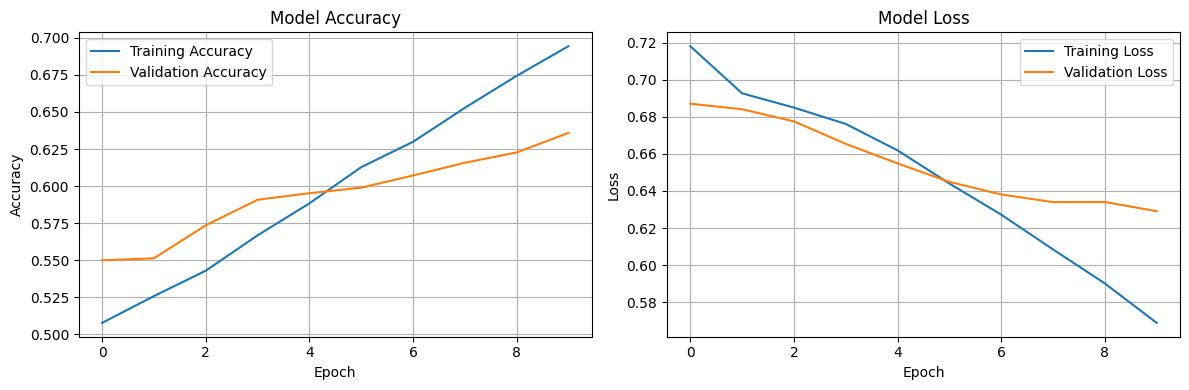

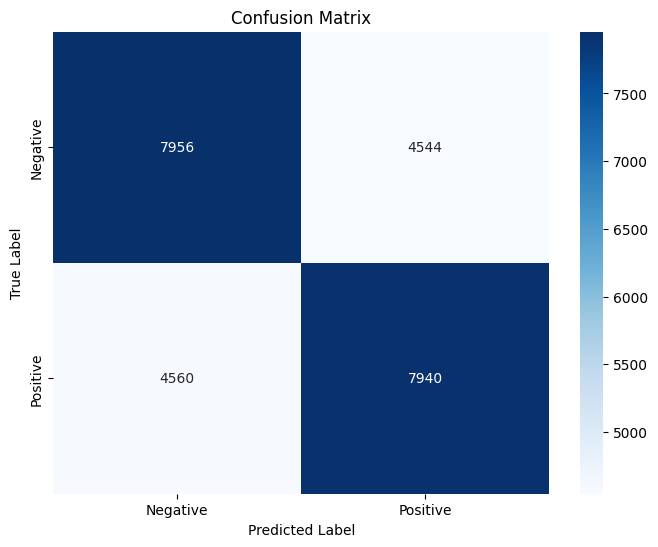


SAMPLE PREDICTIONS
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Sample 1:
Review: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P...
True Label: Positive
Predicted: Positive (Confidence: 0.542)
Prediction Score: 0.542
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Sample 2:
Review: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P...
True Label: Positive
Predicted: Positive (Confidence: 0.955)
Prediction Score: 0.955
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Sample 3:
Review: br br however there are some character problems that i do count as a flaw the penguin has a <UNK> of circus performers who do his

In [12]:
def test_custom_reviews(model, word_index):
    """Test model on custom reviews"""
    print("\n" + "="*50)
    print("CUSTOM REVIEW PREDICTIONS")
    print("="*50)

    custom_reviews = [
        "This movie was absolutely fantastic! The acting was superb and the plot was engaging.",
        "Terrible movie. Boring plot and bad acting. Waste of time.",
        "The movie was okay, nothing special but not terrible either.",
        "Outstanding cinematography and brilliant performances by all actors. Highly recommended!",
        "Disappointing. Expected much more from this director. Very predictable storyline."
    ]

    for i, review in enumerate(custom_reviews):
        sentiment, confidence, score = predict_sentiment(model, review, word_index)
        print(f"\nCustom Review {i+1}: {review}")
        print(f"Predicted: {sentiment} (Confidence: {confidence:.3f}, Score: {score:.3f})")

# Main execution
print("IMDB Sentiment Analysis with RNN")
print("="*50)

# Step 1: Load and preprocess data
X_train, y_train, X_test, y_test, word_index, reverse_word_index = load_and_preprocess_data()

# Step 2: Build the model
model = build_rnn_model()

# Step 3: Train the model
history = train_model(model, X_train, y_train, X_test, y_test)

# Step 4: Evaluate the model
predictions, predicted_labels = evaluate_model(model, X_test, y_test)

# Step 5: Plot training history
plot_training_history(history)

# Step 6: Plot confusion matrix
plot_confusion_matrix(y_test, predicted_labels)

# Step 7: Show sample predictions
show_sample_predictions(model, X_test, y_test, reverse_word_index, word_index)

# Step 8: Test custom reviews
test_custom_reviews(model, word_index)

print("\nTraining and evaluation completed!")

# Optional: Save the model
model.save('imdb_rnn_sentiment_model.h5')
print("Model saved as 'imdb_rnn_sentiment_model.h5'")

# Display final model performance summary
print("\n" + "="*50)
print("FINAL MODEL SUMMARY")
print("="*50)
print(f"Model Architecture: RNN with {RNN_UNITS} units")
print(f"Vocabulary Size: {VOCAB_SIZE}")
print(f"Max Sequence Length: {MAX_LENGTH}")
print(f"Embedding Dimension: {EMBEDDING_DIM}")
print(f"Training Epochs: {len(history.history['accuracy'])}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

# Calculate and display some additional metrics
final_predictions = model.predict(X_test)
final_pred_labels = (final_predictions > 0.5).astype(int).flatten()
accuracy = np.mean(final_pred_labels == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Count positive and negative predictions
pos_count = np.sum(final_pred_labels == 1)
neg_count = np.sum(final_pred_labels == 0)
print(f"Positive predictions: {pos_count} ({pos_count/len(final_pred_labels)*100:.1f}%)")
print(f"Negative predictions: {neg_count} ({neg_count/len(final_pred_labels)*100:.1f}%)")
print("="*50)